<h1 style="text-align:center">Dubins Paths</h1>
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="https://userweb.ucs.louisiana.edu/~jev9637/">https://userweb.ucs.louisiana.edu/~jev9637/</a></p>

The overwelming majority of this code is adapted from that in the _great_ [Python Robotics](https://atsushisakai.github.io/PythonRobotics/) project, by Atsushi Sakai ([@Atsushi_twi](https://twitter.com/Atsushi_twi)). More specifically the [script to generate a single Dubin's path between two points](https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/DubinsPath/dubins_path_planning.py).

The [Wikipedia article](https://en.wikipedia.org/wiki/Dubins_path) on Dubins Paths is fairly well done. At a high-level, these paths are the shortest that connect two points (with orientation) on a plane. The paths are constructed of curves, limited by a curvature limit, possibly connected by a straight line. If a curved path is represented by $C$ and a straight segment by $S$, then the possible paths are either $CCC$ or $CSC$.

### TODO:
- [ ] Switch all `math` to `np` equivalents
- [ ] Improve commenting throughout

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot
from scipy.interpolate import interp1d

In [2]:
# Increase resolution of figures shown in the notebook
%config InlineBackend.figure_format = 'retina'

First, define a few utility functions.

In [3]:
def mod2pi(theta):
    return theta - 2.0 * math.pi * math.floor(theta / 2.0 / math.pi)


def pi_2_pi(angle):
    ''' Wrap angles to within one revolution '''
    return (angle + math.pi) % (2 * math.pi) - math.pi

Now, we'll define functions that map all of the possible curves. We can brute force this operation since the solution space is so small. If $L$ is a left turn, $R$ is a right turn, and $S$ is a straight segment, then the entire set of possible solutions is: ${LSL, RSR, LSR, RSL, RLR, LRL}$.

In [4]:
def left_straight_left(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    tmp0 = d + sa - sb

    mode = ["L", "S", "L"]
    p_squared = 2 + (d * d) - (2 * c_ab) + (2 * d * (sa - sb))
    if p_squared < 0:
        return None, None, None, mode
    
    tmp1 = math.atan2((cb - ca), tmp0)
    
    t = mod2pi(-alpha + tmp1)
    p = math.sqrt(p_squared)
    q = mod2pi(beta - tmp1)

    return t, p, q, mode


def right_straight_right(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    tmp0 = d - sa + sb
    mode = ["R", "S", "R"]
    p_squared = 2 + (d * d) - (2 * c_ab) + (2 * d * (sb - sa))
    if p_squared < 0:
        return None, None, None, mode
    tmp1 = math.atan2((ca - cb), tmp0)
    t = mod2pi(alpha - tmp1)
    p = math.sqrt(p_squared)
    q = mod2pi(-beta + tmp1)

    return t, p, q, mode


def left_straight_right(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    p_squared = -2 + (d * d) + (2 * c_ab) + (2 * d * (sa + sb))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    p = math.sqrt(p_squared)
    tmp2 = math.atan2((-ca - cb), (d + sa + sb)) - math.atan2(-2.0, p)
    t = mod2pi(-alpha + tmp2)
    q = mod2pi(-mod2pi(beta) + tmp2)

    return t, p, q, mode


def right_straight_left(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    p_squared = (d * d) - 2 + (2 * c_ab) - (2 * d * (sa + sb))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    p = math.sqrt(p_squared)
    tmp2 = math.atan2((ca + cb), (d - sa - sb)) - math.atan2(2.0, p)
    t = mod2pi(alpha - tmp2)
    q = mod2pi(beta - tmp2)

    return t, p, q, mode


def right_left_right(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    mode = ["R", "L", "R"]
    tmp_rlr = (6.0 - d * d + 2.0 * c_ab + 2.0 * d * (sa - sb)) / 8.0
    if abs(tmp_rlr) > 1.0:
        return None, None, None, mode

    p = mod2pi(2 * math.pi - math.acos(tmp_rlr))
    t = mod2pi(alpha - math.atan2(ca - cb, d - sa + sb) + mod2pi(p / 2.0))
    q = mod2pi(alpha - beta - t + mod2pi(p))
    return t, p, q, mode


def left_right_left(alpha, beta, d):
    sa = math.sin(alpha)
    sb = math.sin(beta)
    ca = math.cos(alpha)
    cb = math.cos(beta)
    c_ab = math.cos(alpha - beta)

    mode = ["L", "R", "L"]
    tmp_lrl = (6.0 - d * d + 2.0 * c_ab + 2.0 * d * (- sa + sb)) / 8.0
    if abs(tmp_lrl) > 1:
        return None, None, None, mode
    p = mod2pi(2 * math.pi - math.acos(tmp_lrl))
    t = mod2pi(-alpha - math.atan2(ca - cb, d + sa - sb) + p / 2.0)
    q = mod2pi(mod2pi(beta) - alpha - t + mod2pi(p))

    return t, p, q, mode

***TODO***: Explain and comment the functions in the next cell.

In [5]:
def dubins_path_planning_from_origin(end_x, end_y, end_yaw, curvature,
                                     step_size):
    dx = end_x
    dy = end_y
    D = math.hypot(dx, dy)
    d = D * curvature

    theta = mod2pi(math.atan2(dy, dx))
    alpha = mod2pi(- theta)
    beta = mod2pi(end_yaw - theta)

    planners = [left_straight_left, right_straight_right, left_straight_right,
                right_straight_left, right_left_right,
                left_right_left]

    best_cost = float("inf")
    bt, bp, bq, best_mode = None, None, None, None

    for planner in planners:
        t, p, q, mode = planner(alpha, beta, d)
        if t is None:
            continue

        cost = (abs(t) + abs(p) + abs(q))
        if best_cost > cost:
            bt, bp, bq, best_mode = t, p, q, mode
            best_cost = cost
    lengths = [bt, bp, bq]

    x_list, y_list, yaw_list, directions = generate_local_course(
        sum(lengths), lengths, best_mode, curvature, step_size)

    return x_list, y_list, yaw_list, best_mode, best_cost


def interpolate(ind, length, mode, max_curvature, origin_x, origin_y,
                origin_yaw, path_x, path_y, path_yaw, directions):
    if mode == "S":
        path_x[ind] = origin_x + length / max_curvature * math.cos(origin_yaw)
        path_y[ind] = origin_y + length / max_curvature * math.sin(origin_yaw)
        path_yaw[ind] = origin_yaw
    else:  # curve
        ldx = math.sin(length) / max_curvature
        ldy = 0.0
        if mode == "L":  # left turn
            ldy = (1.0 - math.cos(length)) / max_curvature
        elif mode == "R":  # right turn
            ldy = (1.0 - math.cos(length)) / -max_curvature
        gdx = math.cos(-origin_yaw) * ldx + math.sin(-origin_yaw) * ldy
        gdy = -math.sin(-origin_yaw) * ldx + math.cos(-origin_yaw) * ldy
        path_x[ind] = origin_x + gdx
        path_y[ind] = origin_y + gdy

    if mode == "L":  # left turn
        path_yaw[ind] = origin_yaw + length
    elif mode == "R":  # right turn
        path_yaw[ind] = origin_yaw - length

    if length > 0.0:
        directions[ind] = 1
    else:
        directions[ind] = -1

    return path_x, path_y, path_yaw, directions


def dubins_path_planning(s_x, s_y, s_yaw, g_x, g_y, g_yaw, c, step_size=0.1):
    """
    Dubins path planner

    input:
        s_x x position of start point [m]
        s_y y position of start point [m]
        s_yaw yaw angle of start point [rad]
        g_x x position of end point [m]
        g_y y position of end point [m]
        g_yaw yaw angle of end point [rad]
        c curvature [1/m]

    """

    g_x = g_x - s_x
    g_y = g_y - s_y

    l_rot = Rot.from_euler('z', s_yaw).as_matrix()[0:2, 0:2]
    le_xy = np.stack([g_x, g_y]).T @ l_rot
    le_yaw = g_yaw - s_yaw

    lp_x, lp_y, lp_yaw, mode, lengths = dubins_path_planning_from_origin(
        le_xy[0], le_xy[1], le_yaw, c, step_size)

    rot = Rot.from_euler('z', -s_yaw).as_matrix()[0:2, 0:2]
    converted_xy = np.stack([lp_x, lp_y]).T @ rot
    x_list = converted_xy[:, 0] + s_x
    y_list = converted_xy[:, 1] + s_y
    yaw_list = [pi_2_pi(i_yaw + s_yaw) for i_yaw in lp_yaw]

    return x_list, y_list, yaw_list, mode, lengths


def generate_local_course(total_length, lengths, mode, max_curvature,
                          step_size):
    n_point = math.trunc(total_length / step_size) + len(lengths) + 4

    path_x = [0.0 for _ in range(n_point)]
    path_y = [0.0 for _ in range(n_point)]
    path_yaw = [0.0 for _ in range(n_point)]
    directions = [0.0 for _ in range(n_point)]
    index = 1

    if lengths[0] > 0.0:
        directions[0] = 1
    else:
        directions[0] = -1

    ll = 0.0

    for (m, l, i) in zip(mode, lengths, range(len(mode))):
        if l > 0.0:
            d = step_size
        else:
            d = -step_size

        # set origin state
        origin_x, origin_y, origin_yaw = \
            path_x[index], path_y[index], path_yaw[index]

        index -= 1
        if i >= 1 and (lengths[i - 1] * lengths[i]) > 0:
            pd = - d - ll
        else:
            pd = d - ll

        while abs(pd) <= abs(l):
            index += 1
            path_x, path_y, path_yaw, directions = interpolate(
                index, pd, m, max_curvature, origin_x, origin_y, origin_yaw,
                path_x, path_y, path_yaw, directions)
            pd += d

        ll = l - pd - d  # calc remain length

        index += 1
        path_x, path_y, path_yaw, directions = interpolate(
            index, l, m, max_curvature, origin_x, origin_y, origin_yaw,
            path_x, path_y, path_yaw, directions)

    if len(path_x) <= 1:
        return [], [], [], []

    # remove unused data
    while len(path_x) >= 1 and path_x[-1] == 0.0:
        path_x.pop()
        path_y.pop()
        path_yaw.pop()
        directions.pop()

    return path_x, path_y, path_yaw, directions


def plot_arrow(x, y, yaw, length=0.01, width=1.0, fc="r",
               ec="k"):  # pragma: no cover
    """
    Plot arrows to indicate heading/yaw at waypoints
    """

    # TODO: 08/26/20 - JEV - center arrows on datapoint, rather than having
    #                        tails there
    if not isinstance(x, float):
        for (i_x, i_y, i_yaw) in zip(x, y, yaw):
            plot_arrow(i_x, i_y, i_yaw)
    
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=1.5*width, overhang=0.25)
        plt.plot(x, y)

In [6]:
# Define the points that define the path

# For this example, we're going for symmetric waypoints, so 
# we can define x and y displacments and create our waypoints
# using them:
# 
delta_x = 10.0
delta_y = 5.0

start_angle = np.rad2deg(np.arctan2(delta_y, delta_x))

# TODO: Remove the hard-coded start location
start = np.array([0.0, 0.0, start_angle])

# Now, define the list of waypoints to move through, as
# rows in this array. Each row is:
#  x position (m), y position (m), heaidng angle (deg)
waypoints = np.array([[delta_x, delta_y,  0.0],
                      [delta_x, -delta_y, 180.0],
                      [-delta_x, delta_y, 180.0],
                      [-delta_x, -delta_y, 0.0],
                      [0.0, 0.0, start_angle]])


# Finally, define the curvature limit
curvature = 1 / 4.99

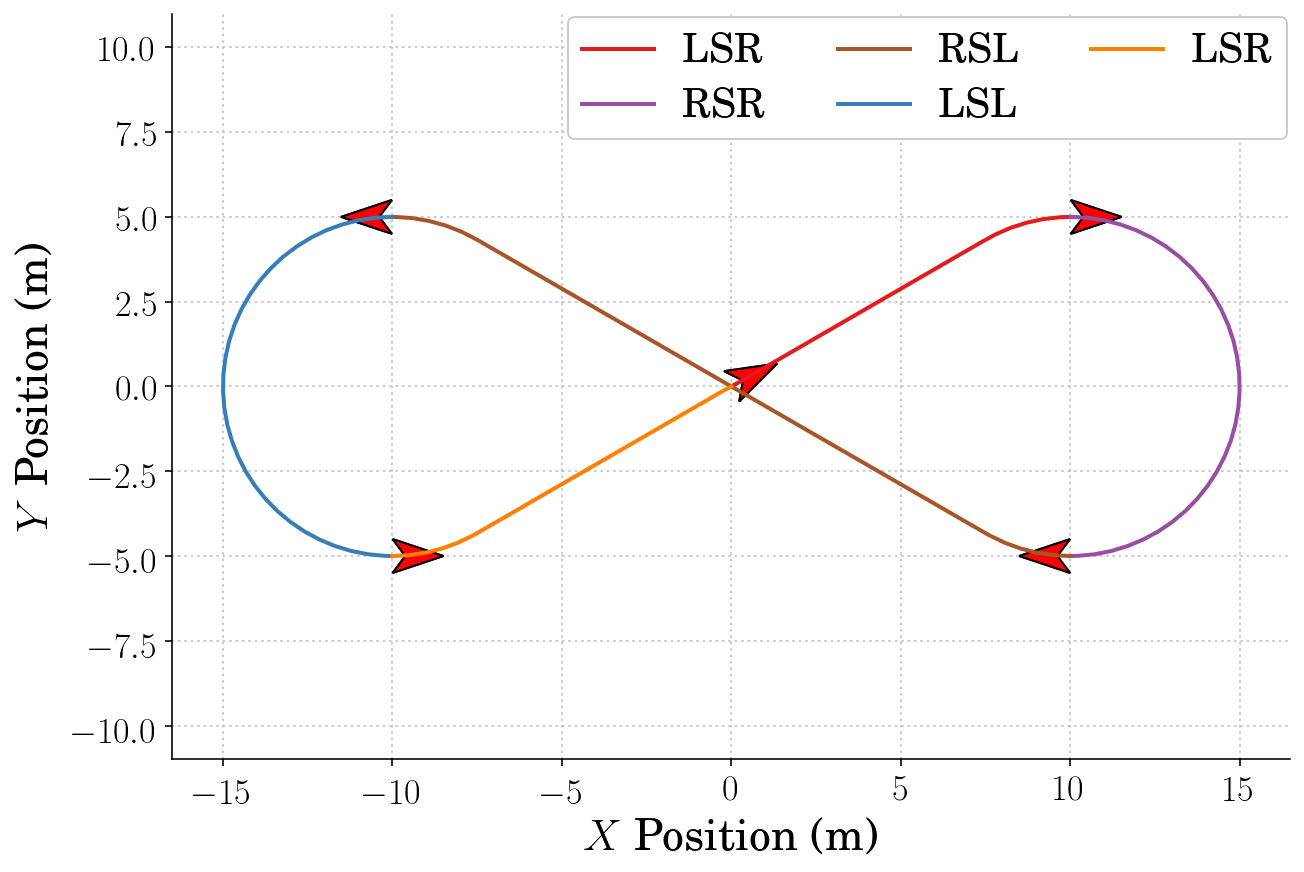

In [7]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

plt.xlabel(r'$X$ Position (m)',family='Serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel(r'$Y$ Position (m)',family='Serif',fontsize=22,weight='bold',labelpad=8)

# TODO: Remove the hard-coded start location
total_path_x = np.array([0])
total_path_y = np.array([0])
total_path_yaw = np.array([start_angle])
total_path_length = 0
total_planar_path_length = 0

path_piece_lengths = np.zeros((len(waypoints) + 1))

# Then, loop over the segments, plotting each one on the same set of axes
for index, waypoint in enumerate(waypoints):
    start_x = start[0]  # [m]
    start_y = start[1]  # [m]
    start_yaw = np.deg2rad(start[2])  # [rad]

    end_x = waypoint[0]  # [m]
    end_y = waypoint[1]  # [m]
    end_yaw = np.deg2rad(waypoint[2])  # [rad]

    start = waypoint

    path_x, path_y, path_yaw, mode, path_length = dubins_path_planning(
        start_x, start_y, start_yaw,
        end_x, end_y, end_yaw, curvature)
    
    planar_length = np.sum(np.abs(path_x) + np.abs(path_y))
    
    # This is an inefficient way tondo this. It'd ge better to pre-allocate the full array and fill it
    # We also 
    total_path_x = np.append(total_path_x, path_x[1:])
    total_path_y = np.append(total_path_y, path_y[1:])
    total_path_yaw = np.append(total_path_yaw, path_yaw[1:])
    total_path_length = total_path_length + path_length
    total_planar_path_length = total_planar_path_length + planar_length
                              
    path_piece_lengths[index] = path_length
    
    plt.plot(path_x, path_y, label="{}".format("".join(mode)))

    plot_arrow(start_x, start_y, start_yaw)
    plot_arrow(end_x, end_y, end_yaw)

    leg = plt.legend(loc='upper right', ncol = 3, fancybox=True)
    ltext  = leg.get_texts()
    plt.setp(ltext, family='serif', fontsize=20)
    plt.axis("equal")
    
    # Adjust the page layout filling the page using the new tight_layout command
    plt.tight_layout(pad=0.5)

# Uncomment to resize the figure for saving. 
# You'll need to double check the layout if you do so.
# fig.set_size_inches(6,4)
# plt.savefig('dubins_path_example.pdf')

The path lenght returned by the Dubins functions does not appear to be the physical path length (It seems to be a cost-function based distance, used to determine which of the possible solutions to use for the move.). However, we can easily calculate that from the path itself.

In [8]:
total_planar_path_length = np.sum(np.abs(total_path_x[1:] - total_path_x[0:-1]) 
                                  + np.abs(total_path_y[1:] - total_path_y[0:-1]))

total_planar_path_length

99.95366482017134

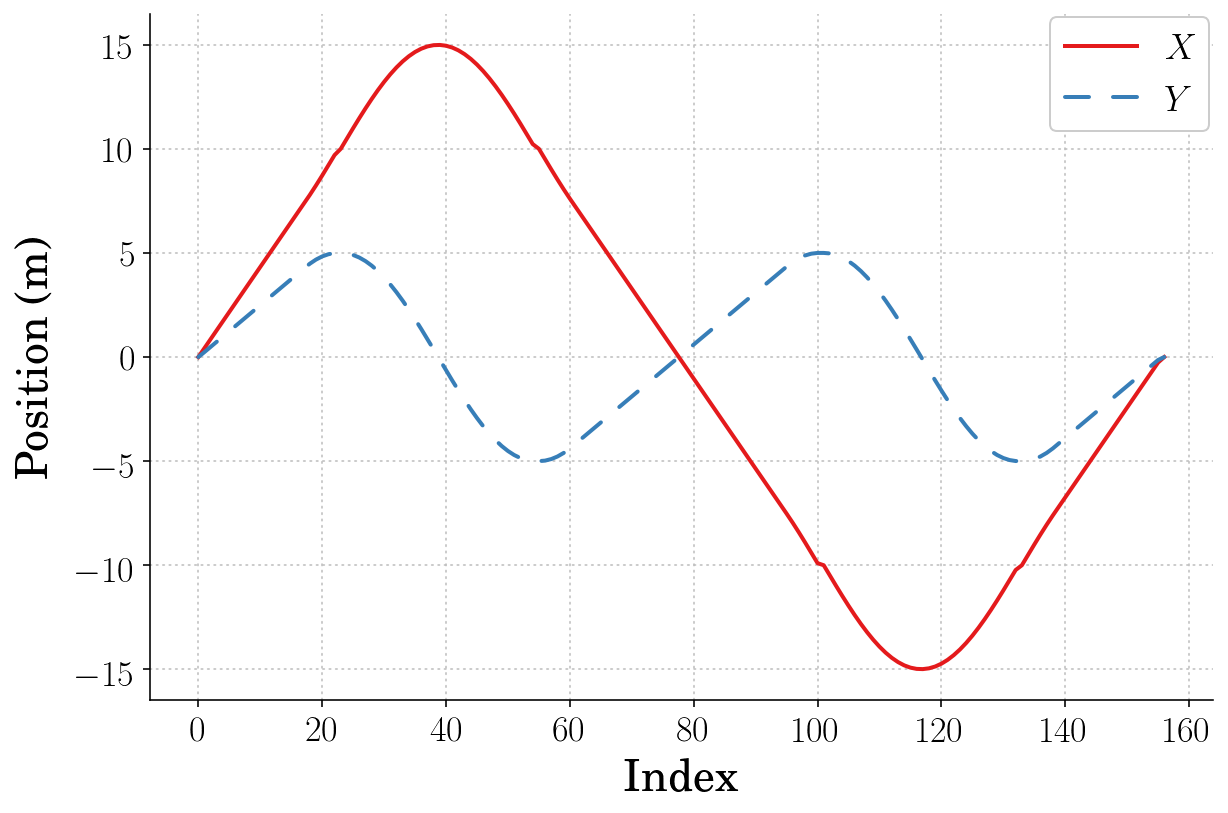

In [9]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units font
plt.setp(ax.get_ymajorticklabels(),fontsize=18)
plt.setp(ax.get_xmajorticklabels(),fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Index', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position (m)', fontsize=22, weight='bold', labelpad=10)
 
plt.plot(total_path_x, linewidth=2, linestyle='-', label=r'$X$')
plt.plot(total_path_y, linewidth=2, linestyle='--', label=r'$Y$')
# plt.plot(total_path_yaw, linewidth=2, linestyle='-.', label=r'Yaw')
#plt.plot(x4, y4, linewidth=2, linestyle=':', label=r'Data 4')

# uncomment below and set limits if needed
# plt.xlim(0,5)
# plt.ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# plt.savefig('plot_filename.pdf')

# increase figure size for notebook viewing
fig.set_size_inches(9,6)

## Creating Functions
It's often convenient to have functionally defined trajectories. [Another file](https://github.com/DocVaughan/CRAWLAB-Code-Snippets/blob/master/Simple%20Simulations/trajectory_interpolation.py) in this repository explores some methods to do either that or increase the resultion of a trajectory's array. Here, we'll use [SciPy's `interp1d()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d). Here, that also provides us a way to specify the timing of this trajectory.

In [10]:
MAX_FORWARD_VEL = 1.5
total_path_time = total_planar_path_length / MAX_FORWARD_VEL  # Min time it should take to complete the trajectory
time_scaling = total_path_time / len(total_path_x)  # Scaling to get returned path array to be the correct time

indices = [x * time_scaling for x in range(len(total_path_x))]
x_path_func = interp1d(indices, total_path_x, kind='cubic')
y_path_func = interp1d(indices, total_path_y, kind='cubic')
yaw_func = interp1d(indices, total_path_yaw, kind='cubic')

Now, let's create finer arrays using those new functions and compare to the original

In [11]:
dt = 0.01  # sample at 100Hz
interp_time = np.arange(0, np.max(indices), dt)

x_from_interp = x_path_func(interp_time)
y_from_interp = y_path_func(interp_time)
yaw_from_interp = yaw_func(interp_time)

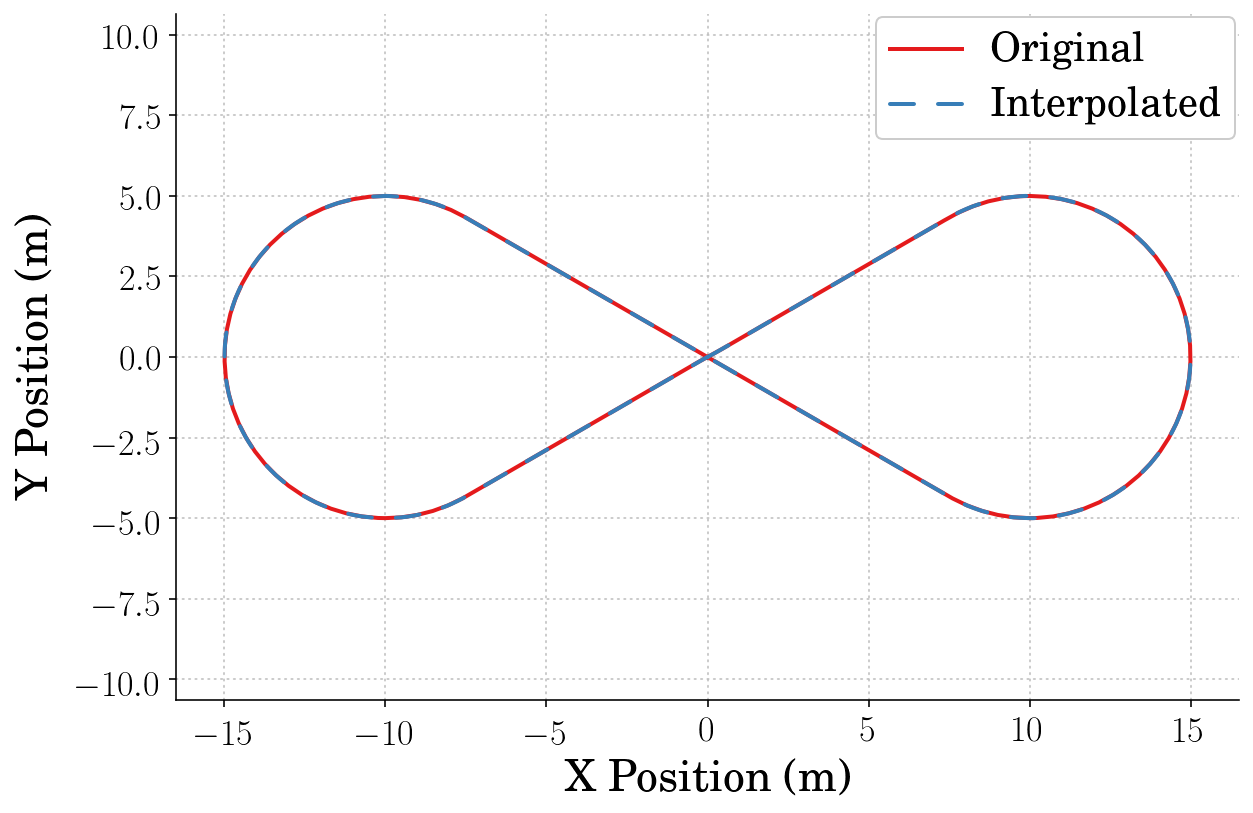

In [12]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('X Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Y Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

plt.plot(total_path_x, total_path_y, linewidth=2, linestyle='-', label=r'Original')
plt.plot(x_from_interp, y_from_interp, linewidth=2, linestyle='--', label=r'Interpolated')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(0, 10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)


plt.axis("equal")

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('plot_filename.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

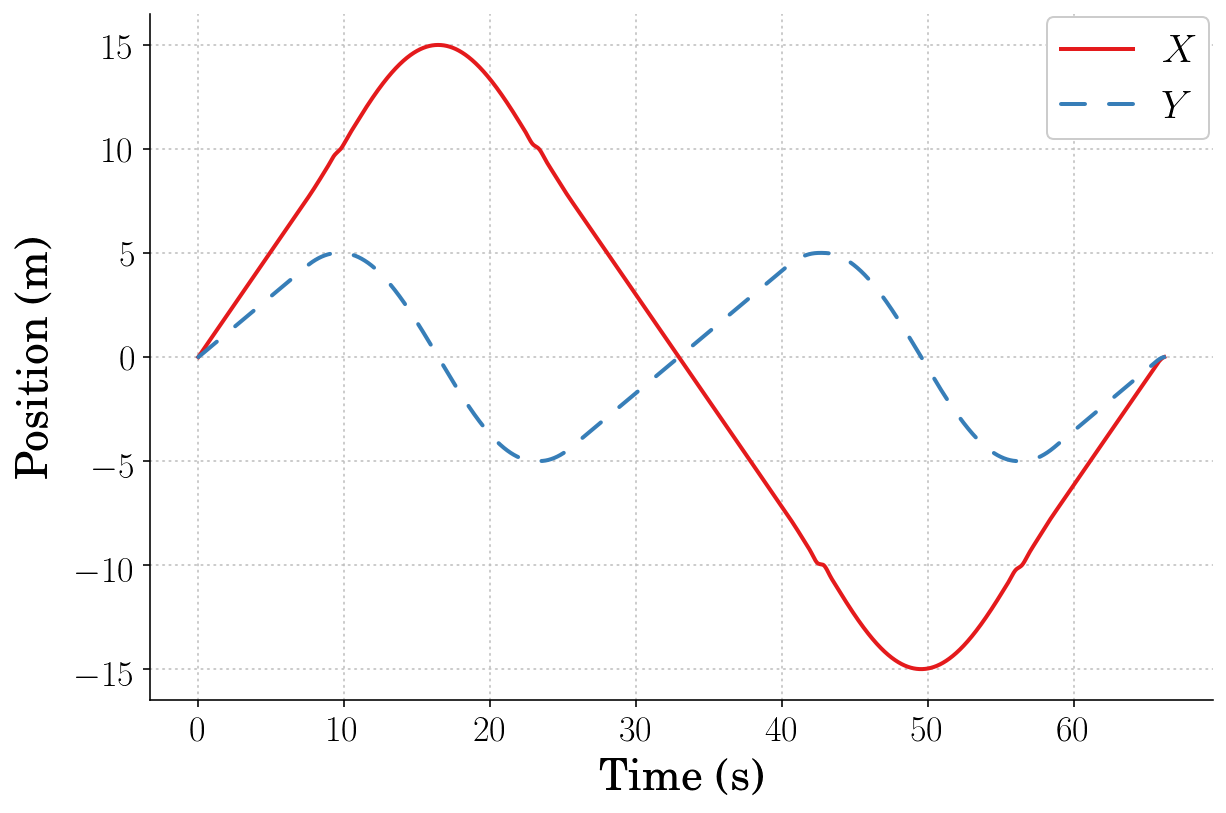

In [13]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

plt.plot(interp_time, x_from_interp, linewidth=2, linestyle='-', label=r'$X$')
plt.plot(interp_time, y_from_interp, linewidth=2, linestyle='--', label=r'$Y$')
# plt.plot(interp_time, yaw_from_interp, linewidth=2, linestyle='-.', label=r'Data 3')
#plt.plot(x4, y4, linewidth=2, linestyle=':', label=r'Data 4')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(0, 10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('plot_filename.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

<hr style="border: 0px;
        height: 1px;
        text-align: center;
        background: #333;
        background-image: -webkit-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:    -moz-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:     -ms-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:      -o-linear-gradient(left, #ccc, #333, #ccc);">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [15]:
# This cell will just improve the styling of the notebook
# You can ignore it, if you are okay with the default sytling
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))